# Calibration and Integration benchmarks

In [16]:
import tables
import numpy as np
import matplotlib.pyplot as plt
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.image import tailcuts_clean
from lstchain.io.io import dl1_images_lstcam_key, dl1_params_lstcam_key
from astropy.table import Table, join, Column, hstack
from ctapipe.io.containers import HillasParametersContainer
import os
import ctaplot
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
from matplotlib.colors import LogNorm

## Loading data

In [69]:
dl1_lstchain_filename = '/fefs/aswg/workspace/thomas.vuillaume/mchdf5/run1/lstchain/dl1_gamma_20deg_180deg_run1___cta-prod3-demo-2147m-LaPalma-baseline-mono_off0.4.simtel.h5'
dl1_hipecta_filename = '/fefs/aswg/workspace/thomas.vuillaume/mchdf5/run1/20200424_dl1_gamma_20deg_180deg_run1___cta-prod3-demo-2147m-LaPalma-baseline-mono_off0.4.h5'
dl1_lstchain_filename = '/fefs/aswg/workspace/thomas.vuillaume/mchdf5/run1/lstchain/GlobalPeakIntegrator/dl1_gamma_20deg_180deg_run1___cta-prod3-demo-2147m-LaPalma-baseline-mono_off0.4.simtel.h5'

dl1_hipecta = tables.open_file(dl1_hipecta_filename)
dl1_lstchain = tables.open_file(dl1_lstchain_filename)

In [70]:
hipecta_images = Table(dl1_hipecta.root.dl1.Tel_1.calib_pic.read())
# hipecta_cleaning = dl1_hipecta.root.dl1.Tel_1.calib_pic.col('clean_mask')
hipecta_images.rename_column('signal', 'image')
hipecta_parameters = Table(dl1_hipecta.root.dl1.Tel_1.parameters.read())

hipecta_parameters['x'] *= 28
hipecta_parameters['y'] *= 28

hipecta = join(hipecta_images, hipecta_parameters, keys='event_id')

In [71]:
lstchain_images = Table(dl1_lstchain.root[dl1_images_lstcam_key].read())
lstchain_parameters = Table(dl1_lstchain.root[dl1_params_lstcam_key].read())

## add p.e. images if available:
pe_image_table = Table(dl1_lstchain.root.dl1.event.simulation.LST_LSTCam.read())
assert len(pe_image_table) == len(lstchain_images)
lstchain_images = hstack([lstchain_images, pe_image_table['photo_electron_image']])

lstchain_images = lstchain_images[lstchain_images['tel_id']==1]
lstchain_parameters = lstchain_parameters[lstchain_parameters['tel_id']==1]

simu_table = Table(dl1_lstchain.root.dl1.event.simulation.LST_LSTCam.read())
simu_table = simu_table[simu_table['tel_id']==1]

lstchain_table = hstack([lstchain_images, simu_table], join_type='exact')
lstchain_table.rename_column('tel_id_1', 'tel_id')
lstchain_table.remove_column('tel_id_2')

lstchain = join(lstchain_images, lstchain_parameters, keys='event_id')

In [72]:
images_table = join(hipecta_images, lstchain_images, keys='event_id', table_names=['hipecta', 'lstchain'])

In [73]:
event_table = join(lstchain, hipecta, table_names=['lstchain', 'hipecta'], keys='event_id')

## Some histograms

Text(0.5, 0, 'pixel integrated charge [p.e.]')

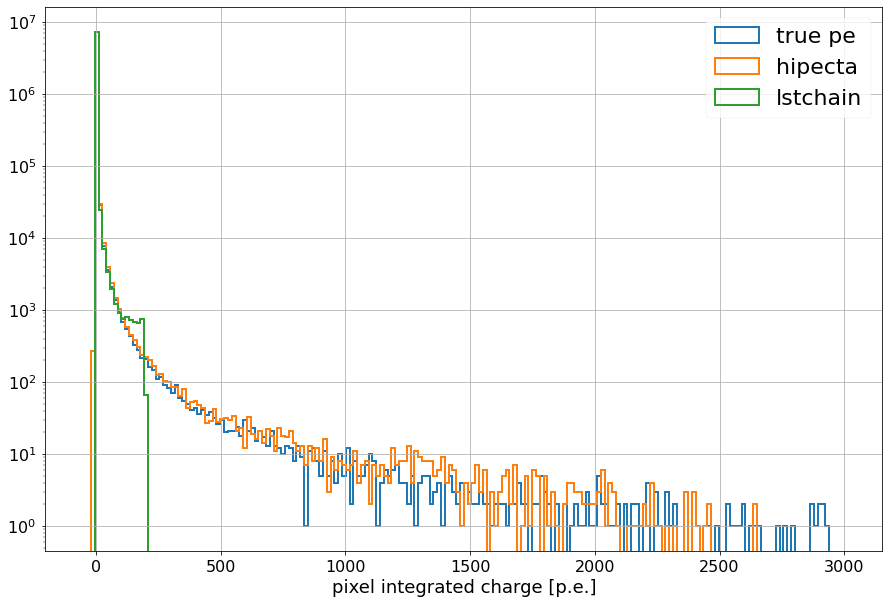

In [74]:
plt.figure(figsize=(15,10))
r = [event_table['photo_electron_image'].min(), event_table['photo_electron_image'].max()]
r = [-50,3000]
opt = dict(bins=200, histtype='step', linewidth=2, range=r, log=True)
plt.hist(event_table['photo_electron_image'].ravel(), label='true pe', **opt);
plt.hist(event_table['image_hipecta'].ravel(), label='hipecta', **opt);
plt.hist(event_table['image_lstchain'].ravel(), label='lstchain', **opt);

plt.grid()
plt.legend(fontsize=22)
plt.xlabel('pixel integrated charge [p.e.]')

## Standard charge integration plots

### lstchain

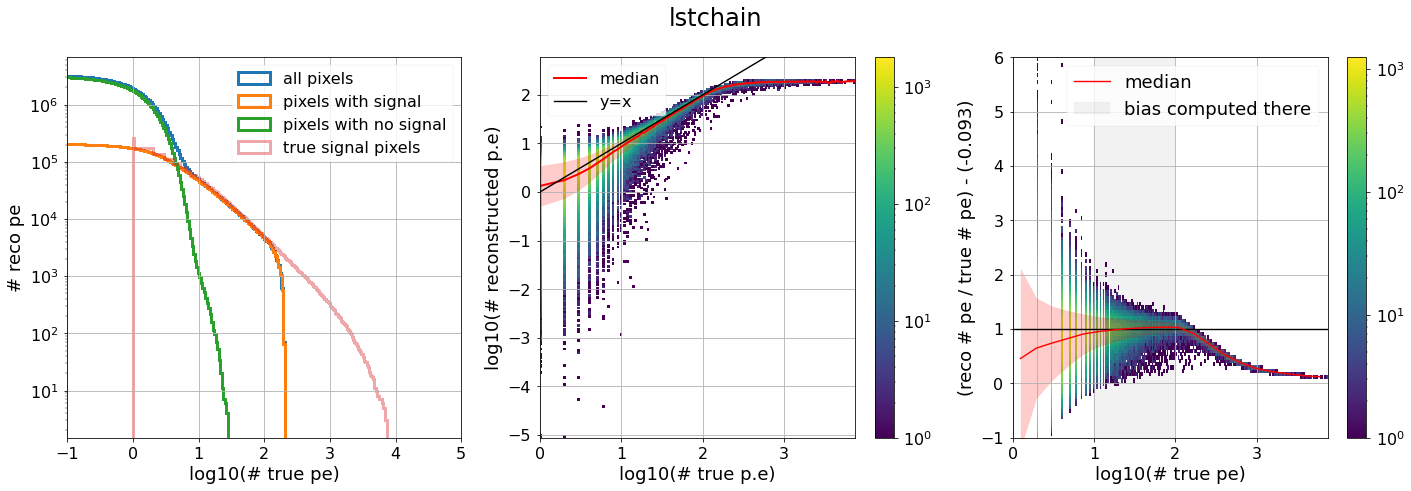

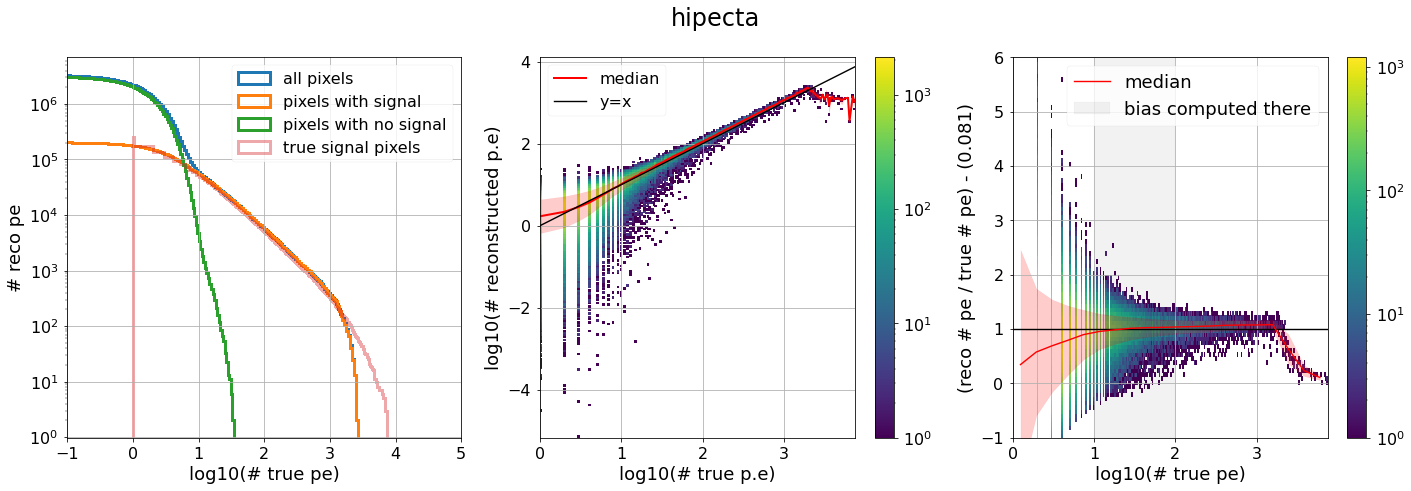

In [75]:
for source in ['lstchain', 'hipecta']:
    fig, axes = plt.subplots(1, 3, figsize=(24,7))
    fig.suptitle(source, fontsize=24)

    ctaplot.plots.calib.plot_pixels_pe_spectrum(images_table['photo_electron_image'], images_table[f'image_{source}'], ax=axes[0])

    ctaplot.plots.calib.plot_photoelectron_true_reco(images_table['photo_electron_image'], images_table[f'image_{source}'], ax=axes[1])

    ctaplot.plots.calib.plot_charge_resolution(images_table['photo_electron_image'], images_table[f'image_{source}'], ax=axes[2], xlim_bias=(10,100))
    axes[2].set_ylim(-1, 6)
    
    plt.show()

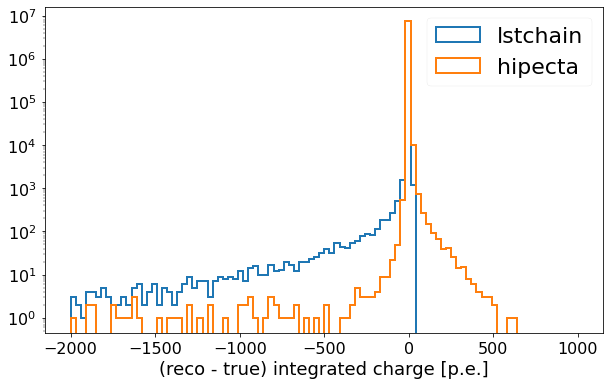

In [76]:
plt.figure(figsize=(10,6))

for source in ['lstchain', 'hipecta']:
    plt.hist(images_table[f'image_{source}'].ravel() - images_table['photo_electron_image'].ravel(), 
             bins=100, 
             range=(-2000, 1000),
             histtype='step', linewidth=2, log=True,
             label=source,
            );
    
plt.xlabel('(reco - true) integrated charge [p.e.]')
plt.legend(fontsize=22);

## Integrated charges on the images

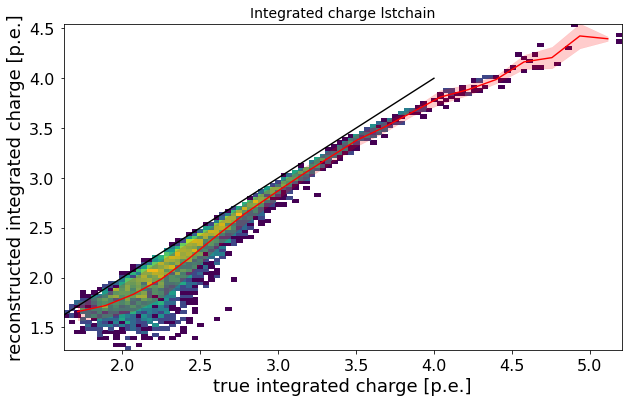

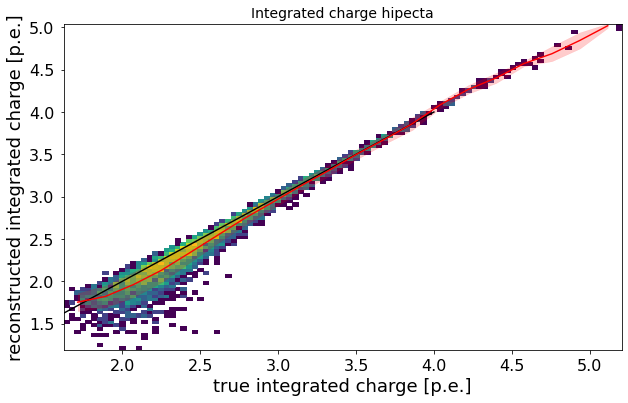

In [77]:
for source in ['lstchain', 'hipecta']:
    plt.figure(figsize=(10,6))
    
    m = event_table[f'intensity_{source}'] > 0
    x = np.log10(event_table['photo_electron_image'].sum(axis=1))[m]
    y = np.log10(event_table[f'intensity_{source}'][m])
    plt.hist2d(x, y, bins=100, norm=LogNorm());
    plt.plot([0,4],[0,4], color='black')
    ctaplot.plot_binned_stat(x, y, errorbar=True, color='red')

    plt.title(f"Integrated charge {source}", fontsize=14)
    plt.xlabel('true integrated charge [p.e.]')
    plt.ylabel('reconstructed integrated charge [p.e.]')
    plt.show()